In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import json

### Description
Objective:
This notebook is to evaluate the data quality issues of 3 datasets: users, brands, and receipts.

Quality Checklist:
- Duplicate Records: check for duplicate rows or duplicate values in primary
key columns
- Missing Values: check for nulls or blanks in critical fields
- Outliers: check extreme values in numerical variables such as pointsEarned, bonusPointsEarned, totalSpent, and purchasedItemCount
- Logical Accuray:
 - createdDate should be before or equal to lastLogin in Users
 - numerical fields such as pointsEarned, bonusPointsEarned, and totalSpent should >= 0
 - purchasedItemCount in Receipts should match the sum of quantityPurchased for the corresponding receiptId in Receipt_Items
 - totalSpent should match the sum of finalPrice for the corresponding receiptId in Receipt_Items


### 1. Users

In [2]:
# load users.json

users = pd.read_json('data/users.json', lines=True)
users = pd.json_normalize(users.to_dict(orient='records'))



In [3]:
# rename and tramsform columns
users.drop(columns=['lastLogin'], inplace=True)
users.rename(columns={'_id.$oid': 'user_id', 'createdDate.$date': 'createdDate', 'lastLogin.$date': 'lastLogin'}, inplace=True)
users['createdDate'] = pd.to_datetime(users['createdDate'], unit='ms')
users['lastLogin'] = pd.to_datetime(users['lastLogin'], unit='ms')
users = users[['user_id', 'active', 'role', 'createdDate', 'lastLogin', 'signUpSource', 'state']]

In [4]:
users.head()

,user_id,active,role,createdDate,lastLogin,signUpSource,state
0,5ff1e194b6a9d73a3a9f1052,True,consumer,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,Email,WI
1,5ff1e194b6a9d73a3a9f1052,True,consumer,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,Email,WI
2,5ff1e194b6a9d73a3a9f1052,True,consumer,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,Email,WI
3,5ff1e1eacfcf6c399c274ae6,True,consumer,2021-01-03 15:25:30.554,2021-01-03 15:25:30.597,Email,WI
4,5ff1e194b6a9d73a3a9f1052,True,consumer,2021-01-03 15:24:04.800,2021-01-03 15:25:37.858,Email,WI


In [5]:
users.shape

(495, 7)

In [6]:
# check null values
users.isnull().sum()

,0
user_id,0
active,0
role,0
createdDate,0
lastLogin,62
signUpSource,48
state,56


In [7]:
# check duplicates
users.duplicated().sum()
print(f"Number of duplicate rows: {users.duplicated().sum()}")
print(f"Percentage of duplicate rows: {users.duplicated().sum()/len(users)*100}%")

Number of duplicate rows: 283
Percentage of duplicate rows: 57.17171717171718%


In [8]:
# remove duplicates
users = users.drop_duplicates()

In [9]:
# reset index
users = users.reset_index(drop=True)

In [10]:
# check null values after remove duplicates
users.isnull().sum()

,0
user_id,0
active,0
role,0
createdDate,0
lastLogin,40
signUpSource,5
state,6


In [11]:
# check dates logic : createdDate <= lastLogin
users[users['createdDate'] > users['lastLogin']]

,user_id,active,role,createdDate,lastLogin,signUpSource,state


In [12]:
users['active'].unique()

array([ True, False])

In [13]:
users['user_id'].nunique()

212

In [14]:
users['role'].unique()

array(['consumer', 'fetch-staff'], dtype=object)

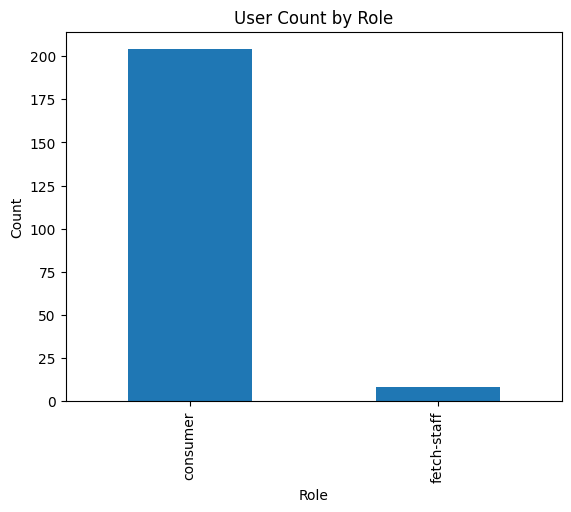

In [15]:
# role distribution
users['role'].value_counts().plot(kind='bar')
plt.xlabel('Role')
plt.ylabel('Count')
plt.title('User Count by Role')
plt.show()

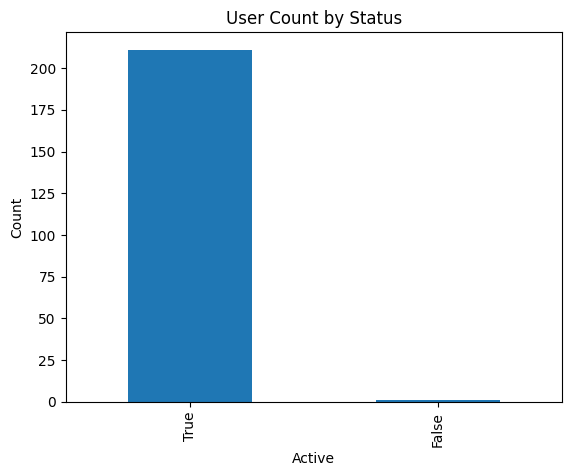

In [16]:
# active vs inactive users
users['active'].value_counts().plot(kind='bar')
plt.xlabel('Active')
plt.ylabel('Count')
plt.title('User Count by Status')
plt.show()

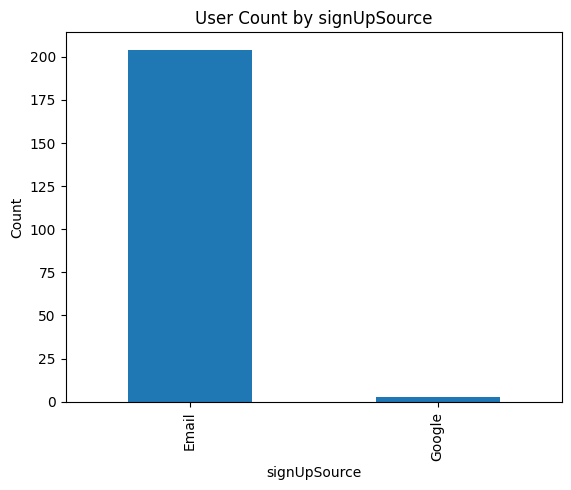

In [17]:
# signUpSource
users['signUpSource'].value_counts().plot(kind='bar')
plt.xlabel('signUpSource')
plt.ylabel('Count')
plt.title('User Count by signUpSource')
plt.show()

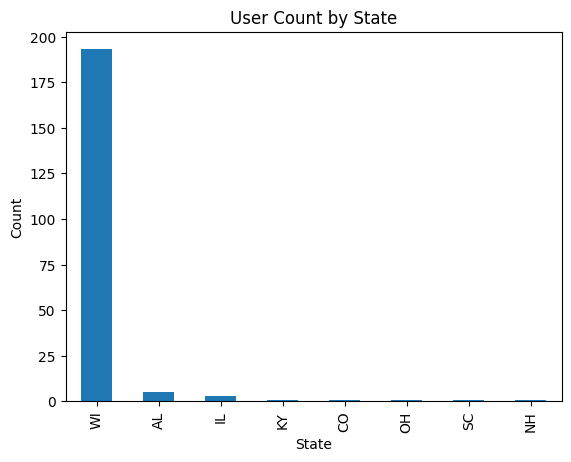

In [18]:
# state
users['state'].value_counts().plot(kind='bar')
plt.xlabel('State')
plt.ylabel('Count')
plt.title('User Count by State')
plt.show()

Most users reside in state of Wisconsin.

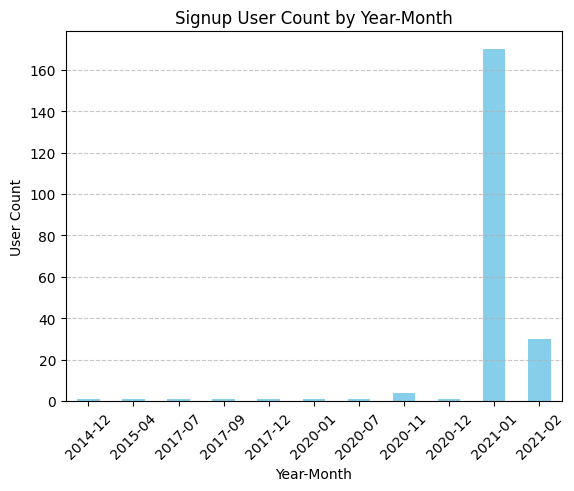

In [19]:
# user count by created year-month
users['year_month'] = users['createdDate'].dt.strftime('%Y-%m')
user_count_by_month = users['year_month'].value_counts().sort_index()

user_count_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Year-Month')
plt.ylabel('User Count')
plt.title('Signup User Count by Year-Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

Most users signed up in January 2021.

### 2. Brands

In [20]:
# load brands.json

brands = pd.read_json('data/brands.json', lines=True)
brands = pd.json_normalize(brands.to_dict(orient='records'))

In [21]:
# rename and tramsform columns
brands.rename(columns={'_id.$oid': 'brand_id', 'cpg.$id.$oid': 'cpg_id', 'cpg.$ref': 'cpg_ref'}, inplace=True)
brands['topBrand'] = brands['topBrand'].map({0.0: False, 1.0: True})
brands = brands[['brand_id', 'name', 'barcode', 'topBrand', 'category', 'categoryCode', 'brandCode', 'cpg_id', 'cpg_ref']]

In [22]:
brands.head()

,brand_id,name,barcode,topBrand,category,categoryCode,brandCode,cpg_id,cpg_ref
0,601ac115be37ce2ead437551,test brand @1612366101024,511111019862,False,Baking,BAKING,NaN,601ac114be37ce2ead437550,Cogs
1,601c5460be37ce2ead43755f,Starbucks,511111519928,False,Beverages,BEVERAGES,STARBUCKS,5332f5fbe4b03c9a25efd0ba,Cogs
2,601ac142be37ce2ead43755d,test brand @1612366146176,511111819905,False,Baking,BAKING,TEST BRANDCODE @1612366146176,601ac142be37ce2ead437559,Cogs
3,601ac142be37ce2ead43755a,test brand @1612366146051,511111519874,False,Baking,BAKING,TEST BRANDCODE @1612366146051,601ac142be37ce2ead437559,Cogs
4,601ac142be37ce2ead43755e,test brand @1612366146827,511111319917,False,Candy & Sweets,CANDY_AND_SWEETS,TEST BRANDCODE @1612366146827,5332fa12e4b03c9a25efd1e7,Cogs


In [23]:
brands.shape

(1167, 9)

In [24]:
# check duplicates
brands.duplicated().sum()

0

In [25]:
# check null values
brands.isnull().sum()

,0
brand_id,0
name,0
barcode,0
topBrand,612
category,155
categoryCode,650
brandCode,234
cpg_id,0
cpg_ref,0


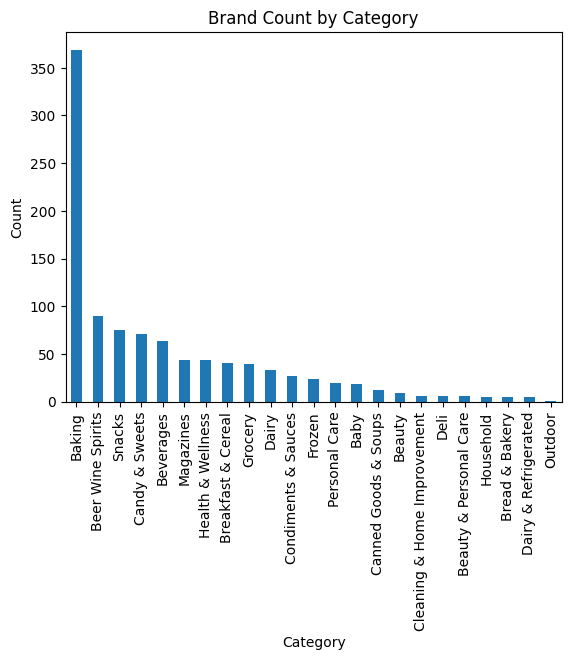

In [26]:
# category distribution
brands['category'].value_counts().plot(kind='bar')
plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Brand Count by Category')
plt.show()

Most brands are baking products.

### 3. Receipts

In [27]:
# load brands.json

receipts = pd.read_json('data/receipts.json', lines=True)
receipts = pd.json_normalize(receipts.to_dict(orient='records'))

In [28]:
# rename and tramsform columns
receipts.drop(columns=['finishedDate', 'pointsAwardedDate', 'purchaseDate'], inplace=True)
receipts.rename(columns={'_id.$oid': 'receipt_id', 'createDate.$date': 'createDate', 'dateScanned.$date': 'scannedDate',
                         'finishedDate.$date': 'finishedDate', 'modifyDate.$date': 'modifyDate',
                         'pointsAwardedDate.$date': 'pointsAwardedDate', 'purchaseDate.$date': 'purchaseDate'}, inplace=True)
receipts['createDate'] = pd.to_datetime(receipts['createDate'], unit='ms')
receipts['scannedDate'] = pd.to_datetime(receipts['scannedDate'], unit='ms')
receipts['finishedDate'] = pd.to_datetime(receipts['finishedDate'], unit='ms')
receipts['modifyDate'] = pd.to_datetime(receipts['modifyDate'], unit='ms')
receipts['pointsAwardedDate'] = pd.to_datetime(receipts['pointsAwardedDate'], unit='ms')
receipts['purchaseDate'] = pd.to_datetime(receipts['purchaseDate'], unit='ms')
receipts = receipts[['receipt_id', 'userId', 'bonusPointsEarned', 'bonusPointsEarnedReason', 'pointsEarned', 'purchasedItemCount',
                  'rewardsReceiptItemList', 'rewardsReceiptStatus', 'totalSpent', 'createDate', 'scannedDate', 'finishedDate',
                  'modifyDate', 'pointsAwardedDate', 'purchaseDate']]

In [29]:
receipts.head()

,receipt_id,userId,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,createDate,scannedDate,finishedDate,modifyDate,pointsAwardedDate,purchaseDate
0,5ff1e1eb0a720f0523000575,5ff1e1eacfcf6c399c274ae6,500.0,"Receipt number 2 completed, bonus point schedu...",500.0,5.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,26.0,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:31,2021-01-03 15:25:36,2021-01-03 15:25:31,2021-01-03 00:00:00
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,150.0,"Receipt number 5 completed, bonus point schedu...",150.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,11.0,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:43,2021-01-03 15:24:48,2021-01-03 15:24:43,2021-01-02 15:24:43
2,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,5.0,All-receipts receipt bonus,5.0,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.0,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,2021-01-03 00:00:00
3,5ff1e1ee0a7214ada100056f,5ff1e1eacfcf6c399c274ae6,5.0,All-receipts receipt bonus,5.0,4.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,28.0,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:34,2021-01-03 15:25:39,2021-01-03 15:25:34,2021-01-03 00:00:00
4,5ff1e1d20a7214ada1000561,5ff1e194b6a9d73a3a9f1052,5.0,All-receipts receipt bonus,5.0,2.0,"[{'barcode': '4011', 'description': 'ITEM NOT ...",FINISHED,1.0,2021-01-03 15:25:06,2021-01-03 15:25:06,2021-01-03 15:25:11,2021-01-03 15:25:11,2021-01-03 15:25:06,2021-01-02 15:25:06


In [30]:
receipts.shape

(1119, 15)

In [31]:
# check duplicates
receipts['receipt_id'].nunique()

1119

In [32]:
# check if there is any negative values
receipts[(receipts['pointsEarned'] < 0) |
         (receipts['bonusPointsEarned']) < 0 |
         (receipts['totalSpent'] < 0) |
         (receipts['purchasedItemCount'] < 0)]

,receipt_id,userId,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,createDate,scannedDate,finishedDate,modifyDate,pointsAwardedDate,purchaseDate


What does each rewardsReceiptStatus mean? Why there is bonus points for status = 'REJECTED'?

In [33]:
receipts[receipts['rewardsReceiptStatus']=='REJECTED']

,receipt_id,userId,bonusPointsEarned,bonusPointsEarnedReason,pointsEarned,purchasedItemCount,rewardsReceiptItemList,rewardsReceiptStatus,totalSpent,createDate,scannedDate,finishedDate,modifyDate,pointsAwardedDate,purchaseDate
2,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,5.0,All-receipts receipt bonus,5.0,1.0,"[{'needsFetchReview': False, 'partnerItemId': ...",REJECTED,10.00,2021-01-03 15:25:37,2021-01-03 15:25:37,NaT,2021-01-03 15:25:42,NaT,2021-01-03 00:00:00
13,5f9c74f70a7214ad07000037,5f9c74f7c88c1415cbddb839,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,11.0,"[{'barcode': '075925306254', 'competitiveProdu...",REJECTED,1.00,2020-10-30 20:17:59,2020-10-30 20:17:59,NaT,2021-01-03 15:24:54,2020-10-30 20:18:00,2020-10-29 20:17:59
28,5ff1e1d40a7214ada1000562,5ff1e194b6a9d73a3a9f1052,NaN,NaN,NaN,3.0,"[{'deleted': True, 'description': 'DELETED ITE...",REJECTED,3.00,2021-01-03 15:25:08,2021-01-03 15:25:08,NaT,2021-01-03 15:25:08,NaT,2017-10-30 00:00:00
62,5ff4a4ca0a7214ada10005d0,5fbc35711d967d1222cbfefc,750.0,"Receipt number 1 completed, bonus point schedu...",750.0,2.0,[{'description': 'mueller austria hypergrind p...,REJECTED,34.96,2021-01-05 17:41:30,2021-01-05 17:41:30,NaT,2021-01-05 17:41:32,NaT,2020-09-13 00:00:00
175,5ff8da570a720f05c5000015,5ff8da28b3348b11c9337ac6,NaN,NaN,NaN,0.0,NaN,REJECTED,0.00,2021-01-08 22:19:03,2021-01-08 22:19:03,NaT,2021-01-08 22:19:04,NaT,NaT
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1106,603c7c6c0a7217c72c0003b3,5fc961c3b8cfca11a077dd33,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,2021-03-01 05:32:28,2021-03-01 05:32:28,NaT,2021-03-01 05:32:29,NaT,2020-08-17 00:00:00
1112,603c3d240a720fde10000373,5fc961c3b8cfca11a077dd33,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,2021-03-01 01:02:28,2021-03-01 01:02:28,NaT,2021-03-01 01:02:29,NaT,2020-08-17 00:00:00
1113,603cc2bc0a720fde100003e9,5fc961c3b8cfca11a077dd33,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,2021-03-01 10:32:28,2021-03-01 10:32:28,NaT,2021-03-01 10:32:29,NaT,2020-08-17 00:00:00
1114,603cc0630a720fde100003e6,5fc961c3b8cfca11a077dd33,25.0,COMPLETE_NONPARTNER_RECEIPT,25.0,2.0,"[{'barcode': 'B076FJ92M4', 'description': 'mue...",REJECTED,34.96,2021-03-01 10:22:27,2021-03-01 10:22:27,NaT,2021-03-01 10:22:28,NaT,2020-08-17 00:00:00


In [34]:
# check null values
receipts.isnull().sum()

,0
receipt_id,0
userId,0
bonusPointsEarned,575
bonusPointsEarnedReason,575
pointsEarned,510
purchasedItemCount,484
rewardsReceiptItemList,440
rewardsReceiptStatus,0
totalSpent,435
createDate,0


There are large numbers of missing values in bonusPointsEarned, bonusPointsEarnedReason, pointsEarned, purchasedItemCount, rewardsReceiptItemList, totalSpent, finishedDate, pointsAwardedDate, purchaseDate.


For the missing values of finishDate, is it beacause the processing of the receipt is not finished yet? Check rewardsReceiptStatus for these records.

In [35]:
# Count null values of finishedDate for each rewardsReceiptStatus category
null_counts = receipts[receipts['finishedDate'].isna()]['rewardsReceiptStatus'].value_counts()
print('null counts for finishedDate')
null_counts

null counts for finishedDate


,count
rewardsReceiptStatus,
SUBMITTED,434
REJECTED,71
FLAGGED,46


So for receipts with a status of 'FINISHED', the finishedDate is not null.

For the missing values of bonusPointsEarned, bonusPointsEarnedReason, pointsEarned and pointsAwardedDate, is it beacause the processing of the receipt is not finished yet? Check rewardsReceiptStatus for these records.

In [36]:
null_counts = receipts[receipts['bonusPointsEarned'].isna()]['rewardsReceiptStatus'].value_counts()
print('null counts for bonusPointsEarned')
null_counts

null counts for bonusPointsEarned


,count
rewardsReceiptStatus,
SUBMITTED,434
FINISHED,62
PENDING,50
FLAGGED,16
REJECTED,13


In [37]:
null_counts = receipts[receipts['pointsEarned'].isna()]['rewardsReceiptStatus'].value_counts()
print('null counts for pointsEarned')
null_counts

null counts for pointsEarned


,count
rewardsReceiptStatus,
SUBMITTED,434
PENDING,50
FLAGGED,13
REJECTED,13


In [38]:
null_counts = receipts[receipts['pointsAwardedDate'].isna()]['rewardsReceiptStatus'].value_counts()
print('null counts for pointsAwardedDate')
null_counts

null counts for pointsAwardedDate


,count
rewardsReceiptStatus,
SUBMITTED,434
REJECTED,67
PENDING,50
FLAGGED,27
FINISHED,4


In [39]:
receipts[receipts['rewardsReceiptStatus']=='FINISHED'].isnull().sum()

,0
receipt_id,0
userId,0
bonusPointsEarned,62
bonusPointsEarnedReason,62
pointsEarned,0
purchasedItemCount,0
rewardsReceiptItemList,2
rewardsReceiptStatus,0
totalSpent,0
createDate,0


For receipts with status of 'FINISHED', there are much less missing values. And for the few missing values in bonusPointsEarned, it is beacuse there is no bonus points, i.e. the value is 0? If it is, suggest to replace null with 0.

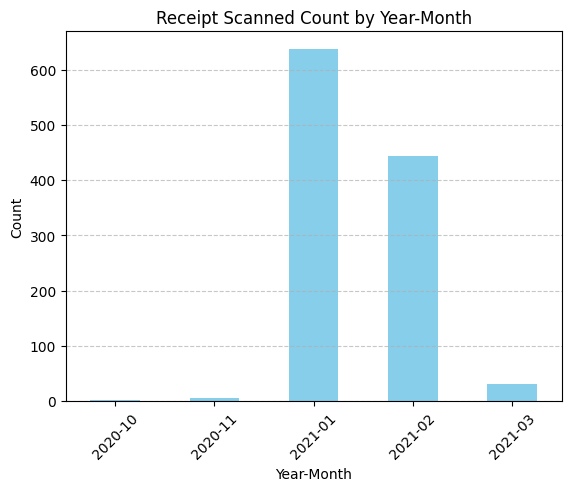

In [40]:
# receipts scanned by year-month
receipts['year_month'] = receipts['scannedDate'].dt.strftime('%Y-%m')
receipt_count_by_month = receipts['year_month'].value_counts().sort_index()

receipt_count_by_month.plot(kind='bar', color='skyblue')
plt.xlabel('Year-Month')
plt.ylabel('Count')
plt.title('Receipt Scanned Count by Year-Month')
plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

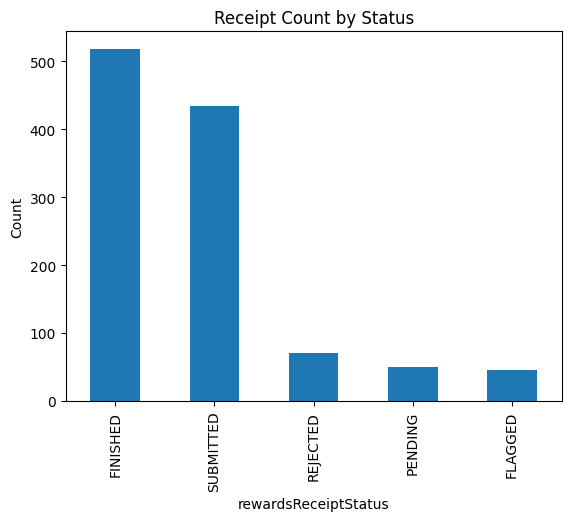

In [41]:
# distribution of rewardsReceiptStatus
receipts['rewardsReceiptStatus'].value_counts().plot(kind='bar')
plt.xlabel('rewardsReceiptStatus')
plt.ylabel('Count')
plt.title('Receipt Count by Status')
plt.show()

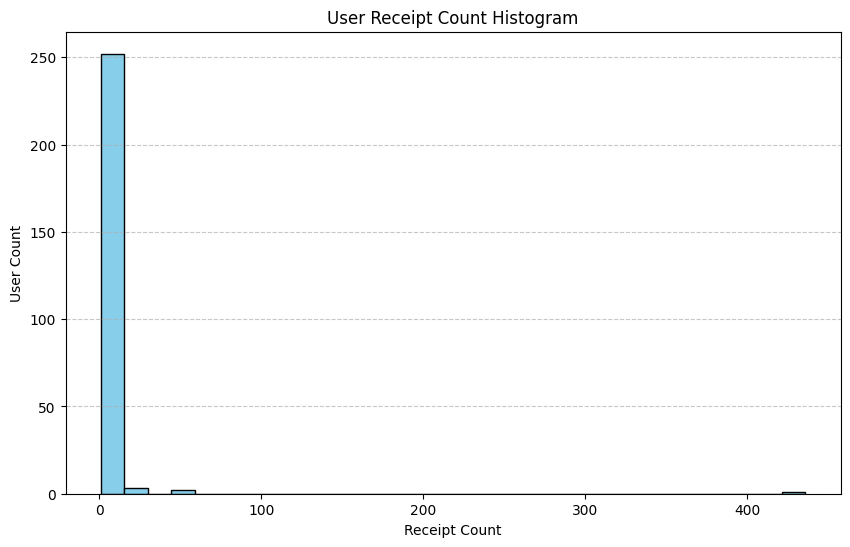

In [42]:
# histogram of receipt count per user
user_receipt_counts = receipts.groupby('userId').size()
plt.figure(figsize=(10, 6))
user_receipt_counts.plot(kind='hist', bins=30, color='skyblue', edgecolor='black')
plt.xlabel('Receipt Count')
plt.ylabel('User Count')
plt.title('User Receipt Count Histogram')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

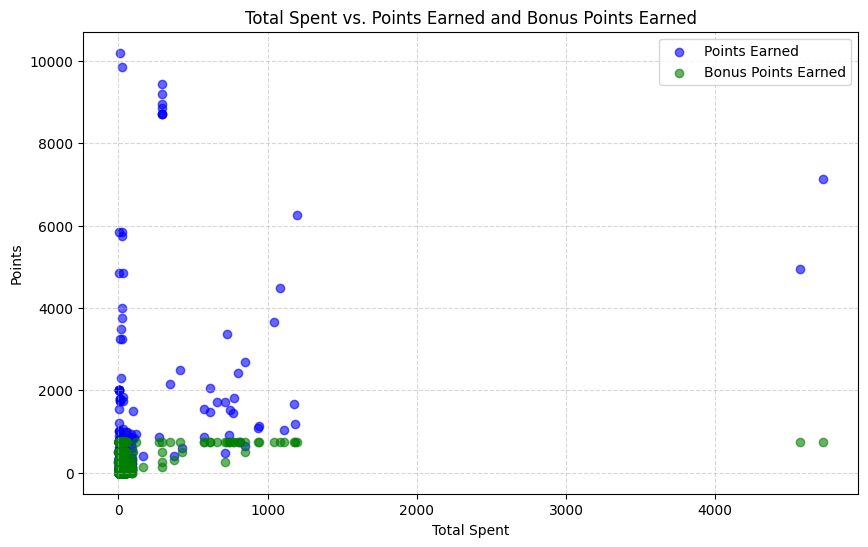

In [43]:
# scartter plot of totalSpent vs pointsEarned and bonusPointsEarned
plt.figure(figsize=(10, 6))
plt.scatter(receipts['totalSpent'], receipts['pointsEarned'], color='blue', alpha=0.6, label='Points Earned')
plt.scatter(receipts['totalSpent'], receipts['bonusPointsEarned'], color='green', alpha=0.6, label='Bonus Points Earned')
plt.xlabel('Total Spent')
plt.ylabel('Points')
plt.title('Total Spent vs. Points Earned and Bonus Points Earned')
plt.legend()
plt.grid(True, linestyle='--', alpha=0.5)
plt.show()

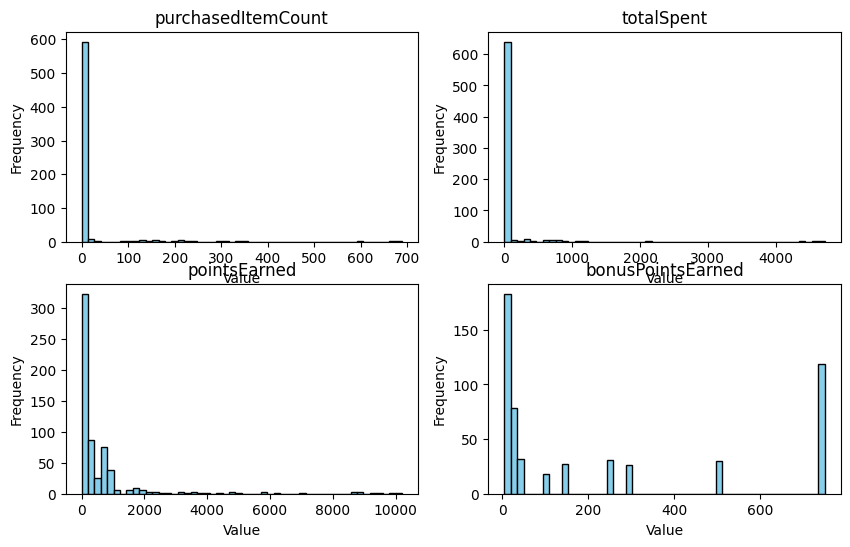

In [44]:
# histogram of purchasedItemCount, totalSpent, pointsEarned and bonusPointsEarned
columns = ['purchasedItemCount', 'totalSpent', 'pointsEarned', 'bonusPointsEarned']
fig, axes = plt.subplots(2, 2, figsize=(10, 6))
axes = axes.flatten()
for i, col in enumerate(columns):
    axes[i].hist(receipts[col].dropna(), bins=50, color='skyblue', edgecolor='black')
    axes[i].set_title(col)
    axes[i].set_xlabel('Value')
    axes[i].set_ylabel('Frequency')
plt.show()

From above plots, it can be found there are extreme large values in purchasedItemCount, totalSpent, pointsEarned and bonusPointsEarned. These values might be outliers and need to be reviewed.

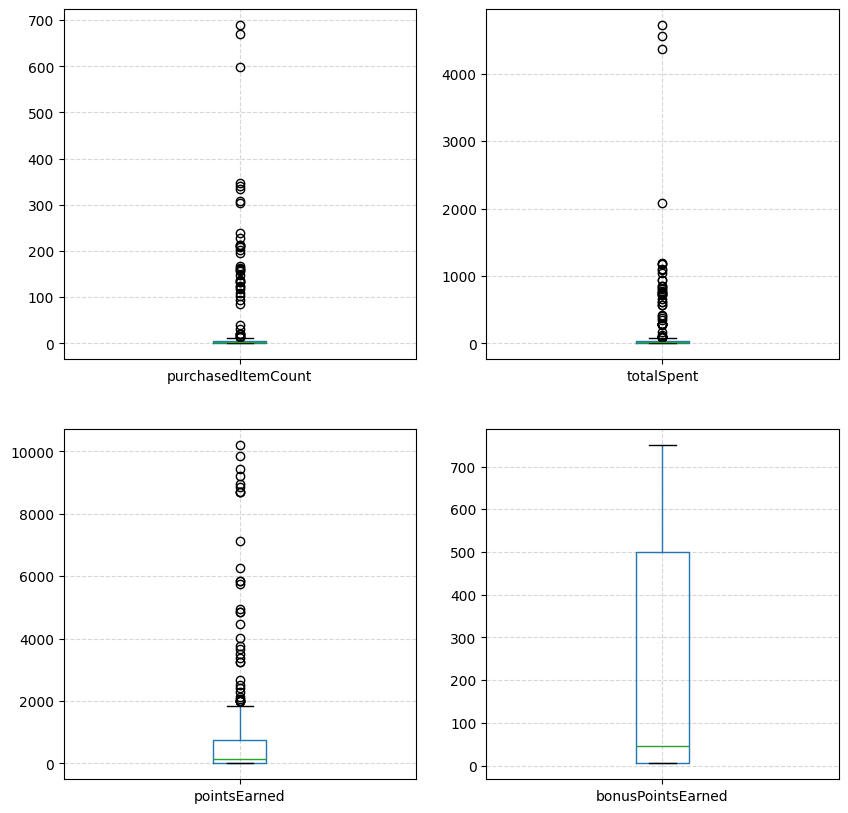

In [45]:
# check outliers with boxplots
columns_to_check = ['purchasedItemCount', 'totalSpent', 'pointsEarned', 'bonusPointsEarned']

fig, axes = plt.subplots(2, 2, figsize=(10, 10))
axes = axes.flatten()
for i, col in enumerate(columns_to_check):
    receipts.boxplot(column=col, ax=axes[i])
    axes[i].grid(True, linestyle='--', alpha=0.5)
plt.show()

The rewardsReceiptItemList column contains the purchased items on the receipt, here we want to check the information of the purchased item is accurate and complete.

In [ ]:
# unnest rewardsReceiptItemList

df = receipts[['receipt_id','userId','purchasedItemCount','totalSpent','rewardsReceiptItemList']]
df['rewardsReceiptItemList'] = df['rewardsReceiptItemList'].apply(lambda x: json.loads(x) if isinstance(x, str) else x)

df = df.dropna(subset=['rewardsReceiptItemList'])
df.reset_index(drop=True, inplace=True)
unnested_df = df.explode('rewardsReceiptItemList')



In [47]:
unnested_df.head()

,receipt_id,userId,purchasedItemCount,totalSpent,rewardsReceiptItemList
0,5ff1e1eb0a720f0523000575,5ff1e1eacfcf6c399c274ae6,5.0,26.0,"{'barcode': '4011', 'description': 'ITEM NOT F..."
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,2.0,11.0,"{'barcode': '4011', 'description': 'ITEM NOT F..."
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,2.0,11.0,"{'barcode': '028400642255', 'description': 'DO..."
2,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,1.0,10.0,"{'needsFetchReview': False, 'partnerItemId': '..."
3,5ff1e1ee0a7214ada100056f,5ff1e1eacfcf6c399c274ae6,4.0,28.0,"{'barcode': '4011', 'description': 'ITEM NOT F..."


In [48]:
unnested_df.reset_index(drop=True, inplace=True)
unnested_df = pd.concat([unnested_df.drop(columns=['rewardsReceiptItemList']),
                         pd.json_normalize(unnested_df['rewardsReceiptItemList'])], axis=1)

In [49]:
unnested_df.head()

,receipt_id,userId,purchasedItemCount,totalSpent,barcode,description,finalPrice,itemPrice,needsFetchReview,partnerItemId,...,itemNumber,originalMetaBriteQuantityPurchased,pointsEarned,targetPrice,competitiveProduct,originalFinalPrice,originalMetaBriteItemPrice,deleted,priceAfterCoupon,metabriteCampaignId
0,5ff1e1eb0a720f0523000575,5ff1e1eacfcf6c399c274ae6,5.0,26.0,4011,ITEM NOT FOUND,26.00,26.00,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,2.0,11.0,4011,ITEM NOT FOUND,1,1,NaN,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,5ff1e1bb0a720f052300056b,5ff1e194b6a9d73a3a9f1052,2.0,11.0,028400642255,DORITOS TORTILLA CHIP SPICY SWEET CHILI REDUCE...,10.00,10.00,True,2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,5ff1e1f10a720f052300057a,5ff1e1f1cfcf6c399c274b0b,1.0,10.0,NaN,NaN,NaN,NaN,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,5ff1e1ee0a7214ada100056f,5ff1e1eacfcf6c399c274ae6,4.0,28.0,4011,ITEM NOT FOUND,28.00,28.00,False,1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [50]:
unnested_df.shape

(6941, 38)

In [51]:
# check how many items purchased have no barcode
print(f"Number of items purchased have no barcode: {len(unnested_df[unnested_df['barcode'].isnull()])}")
print(f"Percentage of items purchased have no barcode: {len(unnested_df[unnested_df['barcode'].isnull()])/len(unnested_df)*100}%")

Number of items purchased have no barcode: 3851
Percentage of items purchased have no barcode: 55.48191903183979%


In [52]:
# check how many items not found: description is 'ITEM NOT FOUND'
print(f"Number of items not found: {len(unnested_df[unnested_df['description'] == 'ITEM NOT FOUND'])}")
print(f"Percentage of items not found: {len(unnested_df[unnested_df['description'] == 'ITEM NOT FOUND'])/len(unnested_df)*100}%")

Number of items not found: 173
Percentage of items not found: 2.492436248379196%


In [ ]:
# check if the sum of quantityPurchased of all items in a receipt macthes the purchasedItemCount
df_receipts = receipts[receipts['purchasedItemCount'].notna()]
df_items = unnested_df[unnested_df['quantityPurchased'].notna()]

df_items['quantityPurchased'] = df_items['quantityPurchased'].astype(int)
df_receipts['purchasedItemCount'] = df_receipts['purchasedItemCount'].astype(int)

quantity_sum = df_items.groupby('receipt_id')['quantityPurchased'].sum().reset_index()
receipt_check = pd.merge(df_receipts[['receipt_id', 'purchasedItemCount']],
                         quantity_sum,
                         on='receipt_id',
                         )

receipt_check['quantity_match'] = receipt_check['purchasedItemCount'] == receipt_check['quantityPurchased']
discrepancies = receipt_check[~receipt_check['quantity_match']]

In [58]:
discrepancies

,receipt_id,purchasedItemCount,quantityPurchased,quantity_match
3,5ff1e1d20a7214ada1000561,2,4,False
12,5f9c74f70a7214ad07000037,11,1,False
17,5ff1e1c80a720f052300056d,2,1,False
22,5ff1e1c60a7214ada100055e,2,1,False
24,5ff1e1cf0a720f0523000570,2,1,False
69,5ff4ce550a7214ada10005db,2,1,False
83,5ff4ce4e0a7214ada10005da,2,1,False
128,5ff726790a7214ada1000602,2,1,False
133,5ff726810a720f05230005ea,2,4,False
135,5ff73bae0a720f0523000600,2,1,False


In [59]:
print(f"Number of receipts with item quantity discrepancies: {len(discrepancies)}")
print(f"Percentage of receipts with item quantity discrepancies: {len(discrepancies)/len(receipts)*100}%")

Number of receipts with item quantity discrepancies: 40
Percentage of receipts with item quantity discrepancies: 3.5746201966041107%


In [ ]:
# check if the sum of finalPrice of all items in a receipt macthes the totalSpent
df_receipts = receipts[receipts['totalSpent'].notna()]
df_items = unnested_df[unnested_df['finalPrice'].notna()]

df_items['finalPrice'] = df_items['finalPrice'].astype(float)
df_receipts['totalSpent'] = df_receipts['totalSpent'].astype(float)

price_sum = df_items.groupby('receipt_id')['finalPrice'].sum().reset_index(name='price_sum')
receipt_check = pd.merge(df_receipts[['receipt_id', 'totalSpent']],
                         price_sum,
                         on='receipt_id',
                         )

#receipt_check['spent_match'] = receipt_check['totalSpent'] == receipt_check['price_sum']
receipt_check['spent_match'] = abs(receipt_check['totalSpent'] - receipt_check['price_sum']) < 0.01
discrepancies = receipt_check[~receipt_check['spent_match']]

In [61]:
discrepancies

,receipt_id,totalSpent,price_sum,spent_match
3,5ff1e1d20a7214ada1000561,1.0,3.56,False
133,5ff726810a720f05230005ea,1.0,3.56,False
155,5ff874050a7214ada100065d,1.0,3.56,False
190,5ffcb4ad0a720f0515000009,1.0,3.56,False
193,5ffc9d9c0a7214adca00004b,10.0,24.00,False
197,5ffcb4b80a7214ad4e00000d,10.0,22.00,False
341,6008888f0a720f05fa0000b5,1.0,3.56,False
444,6011f39c0a720f05350000b4,1.0,3.56,False
489,60132b740a7214ad50000012,1.0,3.56,False
514,60145a510a7214ad50000086,10.0,25.00,False


In [62]:
print(f"Number of receipts with item price discrepancies: {len(discrepancies)}")
print(f"Percentage of receipts with item price discrepancies: {len(discrepancies)/len(receipts)*100}%")

Number of receipts with item price discrepancies: 13
Percentage of receipts with item price discrepancies: 1.161751563896336%
